# Initialization

In [182]:
import pandas as pd
import numpy as np
import os
import datetime
from enum import Enum
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.neural_network import MLPClassifier # Unsupervised
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, RocCurveDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow_decision_forests as tfdf


In [187]:
#Categorize and enumerate all attacks in dataset
ATTACKS = ['DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Benign', 'Web', 'BruteForce']
ATTACKS_ENUM = Enum('ATTACKS', ATTACKS, start=0)
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [54]:
# ===== Generation of CSV data =====
# Adapted from same source as Dataset
run_this = False
if(run_this):
    from pcap2csv import Generating_dataset #Generating_dataset#, Supporting_functions, Communication_features, Connectivity_features, Dynamic_features, Feature_extraction, Layered_features
    import os
    PCAP_DIRECTORY = 'pcap/'
    pcap_files = [k for k in os.listdir(PCAP_DIRECTORY) if k.endswith('.pcap')] 
    Generating_dataset.make_csv(pcap_files)


In [188]:
# =====Split Train / Test data======
# Dataset link-> https://www.unb.ca/cic/datasets/iotdataset-2023.html
#E. C. P. Neto, S. Dadkhah, R. Ferreira, A. Zohourian, R. Lu, A. A. Ghorbani. "CICIoT2023: A real-time dataset and benchmark for large-scale attacks in IoT environment," Sensor (2023) – (submitted to Journal of Sensors).

DATASET_DIRECTORY = 'dataset/'
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] # all files
#df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('1-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')] # smaller subset for faster testing, 17 files =  10% of whole dataset
# df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('11-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')] # 2 files = 1%
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

In [189]:
#=====Extract Data=====

# === PerFlow ===
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
] #columns 0-45
Y_columns = 'label' #column 46

# === PerPacket ===
# X_columns = [
#     'Header_Length', 'Protocol Type', 'Duration',
#         'fin_flag_number', 'syn_flag_number',
#        'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
#        'ece_flag_number', 'cwr_flag_number', 
#     'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
#        'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
# ] #columns 0-45
# Y_columns = 'label' #column 46

all_columns = X_columns+[Y_columns]

NUMERIC_FEATURE_NAMES = [
      'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
      'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 
      'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
      'Radius', 'Covariance', 'Variance', 'Weight', 
]
CATEGORICAL_FEATURE_NAMES = [
      'fin_flag_number', 'syn_flag_number',
      'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
      'ece_flag_number', 'cwr_flag_number','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
      'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
]


In [190]:
#=====Feature Scaling======
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1,1)) # for SVC
for train_set in tqdm(training_sets):
    df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[X_columns]
    scaler.fit(df)
    del df

100%|██████████| 135/135 [03:16<00:00,  1.45s/it]


# Define Model layers

In [191]:
class Model:
    def __init__(self, model, name, type, callbacks=None):
        self.model = model
        self.name = name
        self.type = type
        self.callbacks = callbacks
        #self.batch_size = batch_size

TYPES = {}
TYPES['SK_LR'] = 1
TYPES['SK_RF'] = 2
TYPES['SK_SVC'] = 3
TYPES['TF'] = 4
TYPES['TF_RNN'] = 5
TYPES['TF_CNN'] = 6

verbose, epochs, batch_size = 0, 10, 64
activationFunction='relu'

numFeatures=len(X_columns)
numClasses=len(ATTACKS)

# def getOtimizedSequentialModel():
#     model = Sequential()
#     model.add(Dense(46, activation=activationFunction))
#     model.add(Dense(30, activation=activationFunction))
#     model.add(Dense(8, activation='softmax'))
#     model.compile(loss=keras.losses.BinaryCrossentropy(),
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy(), keras.metrics.FalseNegatives()]
#                     )
#     return model

# def getANN():
#     model = Sequential()
#     model.add(Dense(46, activation=activationFunction))
#     model.add(Dense(30, activation=activationFunction))
#     model.add(Dense(20, activation=activationFunction))
#     model.add(Dense(12, activation=activationFunction))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(loss=keras.losses.BinaryCrossentropy(),
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy(), keras.metrics.FalseNegatives()]
#                     )
#     return Model(model, "ANN", TYPES['TF'])

def getANN():
    model = Sequential()
    model.add(Dense(128, input_dim=numFeatures, activation=activationFunction))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activationFunction))
    model.add(Dense(32, activation=activationFunction))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                    metrics=[ keras.metrics.BinaryAccuracy()]
                    )
    return Model(model, "ANN2", TYPES['TF'])

# def getANN3():
#     model = Sequential()
#     model.add(Dense(128, input_dim=numFeatures, activation=activationFunction))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation=activationFunction))
#     model.add(Dense(32, activation=activationFunction))
#     model.add(Dense(16, activation=activationFunction))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(loss='categorical_crossentropy',
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy()]
#                     )
#     return Model(model, "ANN3", TYPES['TF'])

def getRNN():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return Model(model, "RNN", TYPES['TF_RNN'])

def getCNN():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(numFeatures, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return Model(model, 'CNN', TYPES['TF_CNN'])

# def getCNN2():
#     model = Sequential()
#     model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(numFeatures, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(Dropout(0.5))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     return Model(model, 'CNN', TYPES['TF_CNN'], [early_stopping])

def getRFModel():
    rf = RandomForestClassifier(
        n_estimators=100,
        criterion = 'gini',
        max_depth=None,
        )
    return Model(rf, "RF", TYPES['SK_RF'])

def getDTModel():
    rf = DecisionTreeClassifier(
        criterion = 'gini',
        max_depth=None,
        )
    return Model(rf, "DT", TYPES['SK_RF'])

def getLRModel():
    lr = LogisticRegression()
    return Model(lr, "LR", TYPES['SK_LR'])

def getSVCModel():
    model = SVC()
    return Model(model, "SVCovr", TYPES['SK_SVC'])

def getovoSVCModel():
    model = SVC(decision_function_shape='ovo', verbose=False, cache_size=1000)
    return Model(model, "SVCovo", TYPES['SK_SVC'])

def getLinSVCModel():
    model = LinearSVC(tol = 1e-5)
    return Model(model, "Lin-SVC", TYPES['SK_LR'])

def getSGDCModel():
    return Model(SGDClassifier(loss='log_loss', penalty='l1', alpha=1e-8, max_iter=3000, tol=1e-5, random_state=11), "SGDC", TYPES['SK_LR'])

def getKNNCModel():
    model = KNeighborsClassifier()
    return Model(model, "KNNC", TYPES['SK_LR'])

def getRadNNCModel():
    model = RadiusNeighborsClassifier()
    return Model(model, "RadNNC", TYPES['SK_LR'])

def getNCentModel():
    model = NearestCentroid()
    return Model(model, "NCent", TYPES['SK_LR'])

def getRidgeModel():
    model = RidgeClassifier(solver='saga')
    return Model(model, "Ridge", TYPES['SK_RF'])

def getBNBModel():
    model = BernoulliNB()
    return Model(model, "Bernoulli Naive Bayes", TYPES['SK_LR'])

def getCNBModel():
    model = CategoricalNB()
    return Model(model, "Categorical Naive Bayes", TYPES['SK_LR'])

def getGNBModel():
    model = GaussianNB()
    return Model(model, "Gausian Naive Bayes", TYPES['SK_LR'])

def getMLPCModel():
    model = MLPClassifier() #MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)  
    return Model(model, "MLPC", TYPES['SK_LR'])

def getNUSVCModel():
    model = NuSVC()
    return Model(model, "NuSVC", TYPES['SK_LR'])

mod1 = getKNNCModel()
mod1.name="KNNC2"
mod2 = getKNNCModel()
mod2.name="KNNC3"
mod3 = getCNN()
mod3.name="CNN3"
mod4 = getRNN()
mod4.name="RNN"
mod5 = getSGDCModel()
mod5.name="SGDC"
ML_Models = [
            mod1,
            mod2,
            # mod3,
            # mod4,
            # mod5
]

# Train Models

In [23]:
print(f"Last ran on {len(ML_Models)} models, with {len(training_sets)} training sets on date: {datetime.datetime.now()}")
for train_set in tqdm(training_sets):
    df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
    x_train = scaler.transform(df[X_columns])
    y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]
    y_train_Cat = to_categorical(y_train, num_classes=numClasses)

    for i in range(len(ML_Models)):
            # print(f"model{i}")
            model = ML_Models[i]
            if model.type==TYPES["SK_LR"]:
                model.model.fit(x_train, y_train)  
            
            if model.type==TYPES["SK_SVC"]:
                length = len(x_train) 
                print(length)
                slicesize = length//8
                for j in range(0, length, slicesize):
                    curr_x_train = x_train[j:j+slicesize]
                    curr_y_train = y_train[j:j+slicesize]
                    print(f"training on {j}")
                    model.model.fit(curr_x_train, curr_y_train)
                del curr_x_train

            elif model.type==TYPES["SK_RF"]:
                model.model.fit(x_train, y_train_Cat)  

            elif model.type == TYPES["TF"]:
                model.model.fit(x=x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size) 

            elif model.type == TYPES['TF_RNN']: 
                curr_x_train= np.reshape(x_train, (x_train.shape[0], 1, numFeatures))
                model.model.fit(x=curr_x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size) 
                del curr_x_train

            elif model.type == TYPES['TF_CNN']: 
                curr_x_train= np.reshape(x_train, (x_train.shape[0], numFeatures, 1))
                model.model.fit(x=curr_x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=model.callbacks
                            )    
                del curr_x_train         
    del df
    del x_train
    del y_train
    del y_train_Cat



Last ran on 2 models, with 135 training sets on date: 2024-06-27 09:21:33.652441


100%|██████████| 135/135 [03:22<00:00,  1.50s/it]


# Test the resulting trained models

In [192]:
def showResults(test, pred,model_name):
    output = ''
    output += str(datetime.datetime.now())
    output += f"\n===== {model_name} =====\n"
    output+=classification_report(test, pred, target_names=ATTACKS)
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    output+=f"\nAccuracy  : {accuracy}\n"
    output+=f"Precision : {precision}\n"
    output+=f"f1Score : {f1Score}\n"
    cm=confusion_matrix(test, pred)
    output+=str(cm) 
    
    joblib.dump(output, f"outputs/{model_name}.txt", protocol=1) 

    print(output)


In [193]:
def testModel(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.predict(curr_x_test))
        else:
            y_predict+= list(model.model.predict(x_test))

        del df
        del x_test

    y_test=np.array(y_test)
    if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
        y_test = to_categorical(y_test, num_classes=8)
        y_test = np.argmax(y_test, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
    showResults(y_test, y_predict, model.name)


    del y_test
    del y_predict

In [194]:
# for timing, remove file i/o times
def onlyPredict(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.predict(curr_x_test))
        else:
            y_predict+= list(model.model.predict(x_test))

        del df
        del x_test

    y_test=np.array(y_test)
    if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
        y_test = to_categorical(y_test, num_classes=8)
        y_test = np.argmax(y_test, axis=1)
        y_predict = np.argmax(y_predict, axis=1)


    del y_test
    del y_predict

In [195]:
# for graphing model
# def getBinary(test, pred):
#     return test != ATTACKS_ENUM[dict_7classes["BenignTraffic"]].value, pred != ATTACKS_ENUM[dict_7classes["BenignTraffic"]].value
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
def getROC(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets[:1]):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.decision_function(curr_x_test))
        else:
            y_predict+= list(model.model.predict_proba(x_test))
        # print(y_predict)
        # return
        del df
        del x_test

    y_predict = np.array(y_predict)
    y_test=np.array(y_test)
    label_binarizer.fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    return y_onehot_test, y_predict


    # if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
    #     y_test = to_categorical(y_test, num_classes=8)
    #     y_test = np.argmax(y_test, axis=1)
    #     y_predict_index = np.argmax(y_predict, axis=1)
    # print(f"Precision: {precision_score(y_test, y_predict_index, average='weighted')}")
    # print(y_predict[1])
    # for i in range(len(y_test)):
    #     y_test[i] = (y_test[i] != ATTACKS_ENUM['Benign'].value) 
    #     y_predict[i] = (1- y_predict[i][ATTACKS_ENUM['Benign'].value])

    # print(y_predict[1])
    # print(len(set(y_predict)))
    # return roc_curve(y_test, y_predict)
    

    

In [24]:
for i in range(len(ML_Models)):
    model = ML_Models[i]
    if model.type==TYPES["TF"]:# or model.type==TYPES['TF_CNN'] or model.type==TYPES['TF_RNN']:
        model.model.save(f"SavedModels\\{model.name}.keras",overwrite=True)
    else:
        joblib.dump(model.model, f"SavedModels/{model.name}.pkl") 

In [25]:
print(f"Last ran on {len(ML_Models)} models, with {len(test_sets)} testing sets on date: {datetime.datetime.now()}")
# temp_df_sets=[k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
# test_sets=temp_df_sets[int(len(temp_df_sets)*.8):]
for i in range(len(ML_Models)):
    testModel(ML_Models[i])

Last ran on 2 models, with 34 testing sets on date: 2024-06-27 09:24:56.681639


100%|██████████| 34/34 [46:12<00:00, 81.55s/it] 


2024-06-27 10:11:10.036660
===== KNNC2 =====
              precision    recall  f1-score   support

        DDoS       0.90      0.94      0.92   7526151
         DoS       0.70      0.58      0.63   1792167
       Mirai       0.97      0.98      0.97    583677
       Recon       0.51      0.47      0.49     78630
    Spoofing       0.50      0.39      0.44    107798
      Benign       0.69      0.76      0.73    243322
         Web       0.03      0.01      0.01      5433
  BruteForce       0.82      0.15      0.25      2983

    accuracy                           0.87  10340161
   macro avg       0.64      0.53      0.55  10340161
weighted avg       0.86      0.87      0.86  10340161

Accuracy  : 0.8653204722827816
Precision : 0.8582076734243121
f1Score : 0.8602734859584316
[[7077469  426824    6101    4435    2552    8716      48       6]
 [ 747601 1035530    1433    2981    1221    3384      13       4]
 [   5309    3953  569135     786    2663    1813      11       7]
 [   5838   

100%|██████████| 34/34 [48:55<00:00, 86.34s/it] 


2024-06-27 11:00:34.430701
===== KNNC3 =====
              precision    recall  f1-score   support

        DDoS       0.90      0.94      0.92   7526151
         DoS       0.70      0.58      0.63   1792167
       Mirai       0.97      0.98      0.97    583677
       Recon       0.51      0.47      0.49     78630
    Spoofing       0.50      0.39      0.44    107798
      Benign       0.69      0.76      0.73    243322
         Web       0.03      0.01      0.01      5433
  BruteForce       0.82      0.15      0.25      2983

    accuracy                           0.87  10340161
   macro avg       0.64      0.53      0.55  10340161
weighted avg       0.86      0.87      0.86  10340161

Accuracy  : 0.8653204722827816
Precision : 0.8582076734243121
f1Score : 0.8602734859584316
[[7077469  426824    6101    4435    2552    8716      48       6]
 [ 747601 1035530    1433    2981    1221    3384      13       4]
 [   5309    3953  569135     786    2663    1813      11       7]
 [   5838   

ANN1


100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


RNN


100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


CNN1


100%|██████████| 1/1 [00:16<00:00, 16.12s/it]


DT


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


error at model 3
Found input variables with inconsistent numbers of samples: [1913624, 3827248]
RF1


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


error at model 4
Found input variables with inconsistent numbers of samples: [1913624, 3827248]
KNNC1


100%|██████████| 1/1 [01:04<00:00, 64.03s/it]


Lin-SVC


  0%|          | 0/1 [00:01<?, ?it/s]


error at model 6
'LinearSVC' object has no attribute 'predict_proba'
LR


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


SGDC


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


error at model 8
Input contains NaN.


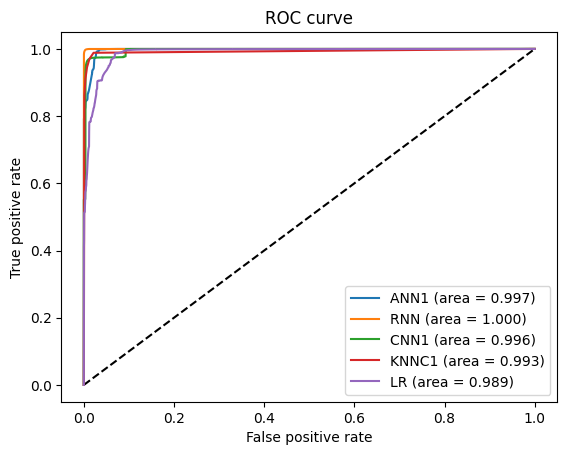

In [196]:
# ===== Prediction time comparison ====
# == Remember to check if correct X_columns
from time import process_time_ns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier 

# test_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] 
folder = 'SavedModels/PerFlow/'
Models = ["ANN1.keras", "RNN.pkl", 'CNN1.pkl', 'DT.pkl', "RF1.pkl", "KNNC1.pkl", "Lin-SVC.pkl","LR.pkl","SGDC.pkl"] # also test RF from modelTooBig
ModelTypes = ["TF", "TF_RNN", 'TF_CNN', 'SK_RF', "SK_RF", "SK_LR", "SK_LR","SK_LR","SK_LR"]
#Models = ["LR.pkl"]
#ModelTypes = ["SK_LR"]

# === TIMING ===
# test_set = test_sets[0] # only for timing, remove for graphing
# df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
# x_test = scaler.transform(df[X_columns])
# y_test = (ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns])
# predictions = len(df)
# output = f'for {predictions} predictions:\n'

# for i in range(len(Models)):
#     model_name = Models[i].split('.')
#     if model_name[1] == 'pkl':
#         model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
#     elif model_name[1] == 'keras':
#         model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
#     else:
#         print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')
#         raise Exception 
    # curr_time = process_time_ns()
    # onlyPredict(model) 
    # timeTaken = process_time_ns() - curr_time
    # output += f"Model {Models[i]} took {timeTaken} ns = {timeTaken/predictions} ns/pred\n"
# joblib.dump(output, f"outputs/PerPacketTimes.txt", protocol=1) 




#=== GRAPHING ===
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(0, len(Models)):
    model_name = Models[i].split('.')
    if model_name[1] == 'pkl':
        model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    elif model_name[1] == 'keras':
        model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    else:
        print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')
        raise Exception
        
    # try:
        # toDisplay = RocCurveDisplay.from_estimator(model.model, x_test, y_test, name=model_name[0])
        # toDisplay.plot()
    # except Exception as e:
        # print(f"graphing failed for {model_name[0]}")
        # print(e)
    # model.model = OneVsRestClassifier(model.model)
    
    print(model_name[0])
    try:
        y_onehot_test, y_predict = getROC(model)
    # print(y_onehot_test.shape)
    # print(y_predict.shape)
    # print(y_predict[0])
    # print(y_onehot_test.ravel().shape)

    # class_of_interest = ATTACKS_ENUM['Benign'].value
    # display = RocCurveDisplay.from_predictions(
    #     y_onehot_test.ravel(),
    #     y_predict.ravel(),
    #     name=f"{class_of_interest} vs the rest",
    #     color="darkorange",
    #     plot_chance_level=True,
    # )
    # display.ax_.set(
    #     xlabel="False Positive Rate",
    #     ylabel="True Positive Rate",
    #     title="Micro-averaged One-vs-Rest\nAttack Detection",
    # ) 
        # if (ModelTypes[i]=="SK_RF"):
        #     # y_raveled = []
        #     # print(f"len y_onehot_test: {len(y_onehot_test)}")
        #     # for i in range(len(y_onehot_test)):
        #     #     y_raveled.append(y_onehot_test[i])
        #     # print(f"len y_raveled: {len(y_raveled)}")
        #     # fpr, tpr, _ = roc_curve(y_raveled, y_predict)
        #     y_pred = y_predict[:,:,0]
        #     y_pred = np.array(y_pred)
        #     y_pred = np.transpose(y_pred)
        #     # print(f"y_pred after cutting {y_pred.shape}")
        #     fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_pred.ravel())
        # else:

        fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_predict.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name[0]} (area = {roc_auc:.3f})')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
    except Exception as e:
        print(f"error at model {i}")
        print(e)
#     fpr, tpr, _ = getROC(model)
#     print(len(fpr))
#     print(len(tpr))
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{model_name[0]} (area = {roc_auc:.3f})')
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=model_name[0])

plt.savefig(fname='outputs/PerFlowGraph.png')
plt.show()



In [123]:
# print(fpr)
print(len(set(tpr)))

372919


In [85]:
sum_datapoints = 0
for test_set in test_sets:
    df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
    sum_datapoints+=len(df)
print(sum_datapoints)

10340161


In [43]:
# times = [10031250000, 19765625000, 26000000000, 1750000000, 7687500000, 355734375000, 1656250000, 1656250000, 1875000000]
# predictions = 269253
# for time in times:
#     print(f"{time/predictions} ns/pred")

37255.85230248131 ns/pred
73409.11707576146 ns/pred
96563.45518898583 ns/pred
6499.463330027892 ns/pred
28551.213914051095 ns/pred
1321190.0145959377 ns/pred
6151.277794490684 ns/pred
6151.277794490684 ns/pred
6963.71071074417 ns/pred


In [13]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     # 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'loss': ['log_loss'],
#     'penalty': ['l2', 'l1'],
#     # 'penalty': ['l2'],
#     'alpha': [1e-10, 1e-9, 1e-8, 1e-7],
#     'max_iter': [1000],
#     'tol': [1e-5]
# }
# grid_search = GridSearchCV(SGDClassifier(), param_grid, scoring='accuracy', n_jobs=-1)
# print(f"Last ran on grid, with {len(training_sets)} training sets on date: {datetime.datetime.now()}")
# for train_set in tqdm(training_sets):
#     df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
#     x_train = scaler.transform(df[X_columns])
#     y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]

#     grid_search.fit(x_train, y_train)                   
#     del df
#     del x_train
#     del y_train


In [14]:
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# print("Best Parameters:", best_params)
# testModel(Model(best_model, "SGDC FromGrid", TYPES["SK_LR"]))
# # print("Best Model Accuracy:", best_model.score(x_test, y_test))
# # print("Best Model Classification Report:\n", classification_report(y_test, best_model.predict(X_test)))
# # print("Best Model Confusion Matrix:\n", confusion_matrix(y_test, best_model.predict(X_test)))

In [16]:
#====For debug ===
# test_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] 
#testModel(Model(load_model("SavedModels\\BestANN.keras"),"BestANN", TYPES['TF']))
# testModel(Model(joblib.load("SavedModels/BestRF.pkl"),"BestRF", TYPES['SK_RF']))

In [17]:
# model = getSimpleRFModel()
# num_sample = 10
# for train_set in tqdm(training_sets):
#     df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
#     df = df[0:num_sample]
#     x_train = scaler.transform(df[X_columns])
#     y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]
#     y_train_Cat = to_categorical(y_train, num_classes=8)

    
#     if model.type==TYPES["SK_LR"]:
#         model.model.fit(x_train, y_train)  
    
#     elif model.type==TYPES["SK_RF"]:
#         model.model.fit(x_train, y_train_Cat)  

#     elif model.type == TYPES["TF"]:
#         model.model.fit(x=x_train, 
#                     y=y_train_Cat, 
#                     epochs=epochs, 
#                     verbose=verbose,
#                     batch_size=batch_size)                   
#     del df
#     del x_train
#     del y_train
#     del y_train_Cat

In [ ]:
# # Tree Visualisation
# from sklearn.tree import export_graphviz
# import matplotlib.pyplot as plt
# from sklearn import tree
# rf = joblib.load("SavedModels/BestRF.pkl")
# for tree_in_rf in rf:
#     fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
#     # export_graphviz(tree,
#     #             feature_names=X_columns,
#     #             class_names=ATTACKS,
#     #             filled=True,
#     #             rounded=True)
#     tree.plot_tree(rf.estimators_[0],
#                 feature_names=X_columns,
#                 class_names=ATTACKS,
#                filled = True)
#     fig.savefig(f'rf_{i}.png')
#     i+=1
# for tree_in_rf in rf[:1]:
#     export_graphviz(tree_in_rf,
#                 feature_names=X_columns,
#                 class_names=ATTACKS,
#                 filled=True,
#                 rounded=True,
#                 out_file="tree.png")
#     os.system("-Tpng tree.dot -o tree.png")
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(model.model.estimators_[0])#,
#             # feature_names=X_columns,
#             # class_names=ATTACKS,
#             # filled = True)
# fig.savefig(f'rf_{num_sample}_samples.png')



# # == Feature importance for RF and DT

# Save Models

In [19]:
# for i in range(len(ML_Models)):
#     model = ML_Models[i]
#     if model.type==TYPES["TF"]:
#         model.model.save(f"SavedModels\\{model.name}.keras",overwrite=True)
#     elif model.type==TYPES["SK_RF"] or model.type==TYPES["SK_LR"]:
#         joblib.dump(model.model, f"SavedModels/{model.name}.pkl") 

# Train a seperate model to detect each attack

In [20]:
# verbose, epochs, batch_size = 1, 100, 512
# activationFunction='relu'

# def getSequentialModel():
#     model = Sequential()
#     model.add(Dense(128, activation=activationFunction))
#     model.add(Dense(64, activation=activationFunction))
#     model.add(Dense(32, activation=activationFunction))
#     model.add(Dense(16, activation=activationFunction))
#     model.add(Dense(8, activation=activationFunction))
#     model.add(Dense(4, activation=activationFunction))
#     model.add(Dense(2, activation='softmax'))
#     model.compile(loss=keras.losses.BinaryCrossentropy(),
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy(), keras.metrics.FalseNegatives()]
#                     )
#     return model

# ML_Models = [
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel(),
#             getSequentialModel()

# ]
# ML_Model_Names = ATTACKS

In [21]:
# print(f"Last ran on {len(ML_Models)} models, with {len(training_sets)} training sets on date: {datetime.datetime.now()}")
# for train_set in tqdm(training_sets):
#     df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
#     x_train = scaler.transform(df[X_columns])

#     for i in range(len(ML_Models)-1):
#             y_train = to_categorical([ATTACKS_ENUM[dict_7classes[k]].value == ATTACKS_ENUM[ATTACKS[i]].value for k in df[Y_columns]], num_classes=2)
#             model = ML_Models[i]
#             model.fit(x=x_train, 
#                         y=y_train, 
#                         epochs=epochs, 
#                         verbose=verbose,
#                         batch_size=batch_size)   
#             del y_train             
#     del df
#     del x_train

In [22]:
# def showResults8Models(test, pred, model_num):
#     print(f"===== {model_num} =====")
#     print(classification_report(test, pred, target_names=["Negative", "Positive"]))
#     accuracy = accuracy_score(test, pred)
#     precision=precision_score(test, pred, average='weighted')
#     f1Score=f1_score(test, pred, average='weighted') 
#     print("Accuracy  : {}".format(accuracy))
#     print("Precision : {}".format(precision))
#     print("f1Score : {}".format(f1Score))
#     cm=confusion_matrix(test, pred)
#     print(cm) 

# print(f"Last ran on {len(ML_Models)} models, with {len(test_sets)} testing sets on date: {datetime.datetime.now()}")
# for i in range(len(ML_Models)):
#     model = ML_Models[i]
#     y_test = []
#     y_predict = []
#     for test_set in tqdm(test_sets):
#         df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
#         x_test = scaler.transform(df[X_columns])
#         for k in df[Y_columns]:
#             y_test.append(ATTACKS_ENUM[dict_7classes[k]].value==ATTACKS[i])
#         y_predict+= list(model.predict(x_test))

#         del df
#         del x_test

#     myarr = np.array([ATTACKS_ENUM[dict_7classes[k]].value == ATTACKS_ENUM[ATTACKS[0]].value for k in ['DDoS-RSTFINFlood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DoS-SYN_Flood','DoS-TCP_Flood','Mirai-udpplain','Recon-OSScan','DNS_Spoofing','BrowserHijacking','Backdoor_Malware','DictionaryBruteForce']])
#     print(myarr)
#     print(to_categorical(myarr, num_classes=2))
#     y_test=np.array(y_test)
#     print(y_test[0:10])
#     y_test = to_categorical(y_test, num_classes=2)
#     print(y_test[0:10])
#     print("=========")
#     for i in range(10):
#         print(f"{i}: {y_predict[i]} actual {y_test[i]}")    

#     test = np.argmax(y_test, axis=1)
#     predict = np.argmax(y_predict, axis=1)
#     showResults8Models(test, predict, i)

#     del test
#     del predict
#     del y_test
#     del y_predict